In [42]:
# what are the most dangerous types of sharks to humans?
# histogram met aantal aanvallen per type haai

# are children more likely to be attacked by sharks?
# are shark attacks where sharks were provoked more or less dangerous?
# are certain activities more likely to result in a shark attack?

# Imports and ingesting data

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/edebrouwert/SharkAttack/main/attacks.csv", encoding='cp1252')

#drop unnecessary columns. To answer the questions, we only need columns Type, Activity, Age, Fatal (maybe) and Species
df.drop(columns=["Country", "Area", "Location", "Date", "Year", "Time", "Name", "Sex ", "Injury", "Investigator or Source", "pdf", "href formula", "href", "Case Number.1", "Case Number.2", "original order", "Unnamed: 22", "Unnamed: 23" ], inplace=True)

#Rename some columns
df.rename(columns= {"Fatal (Y/N)": "Fatal", "Species ": "Species"}, inplace=True)

#Check average null values per column

df.isnull().mean()

Case Number    0.661704
Type           0.755161
Activity       0.776154
Age            0.865062
Fatal          0.775959
Species        0.865335
dtype: float64

# Define functions for finding and replacing missing values

In [44]:

def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)

def look_at_unique_values(column): 
  unique_values_cutoff = 160
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values:")
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values)
      print("Values are sorted")
      display(list(sorted))
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff}")

def look_at_edges(df, column_name):
  # inner function
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f"Could not sort values: {error}")
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)
      #possibly you will get an error here. 
      #Then you know that there is at least one value with a data type that's different than the rest


def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")

def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]  

   # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)

  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")

def replace_value(df, column_name, missing_old, missing_new):
  # ⚠️ Mutates df
  df[column_name] = df[column_name].replace({missing_old: missing_new})




# Clean data per column

In [45]:
#find_non_default_missing_values(df, "Type", "string")
#find_non_default_missing_values(df, "Activity", "string")
#find_non_default_missing_values(df, "Age", "int")
#find_non_default_missing_values(df, "Fatal", "bool")
#find_non_default_missing_values(df, "Species", "string")


#Clean Activity column
replace_value(df, "Activity", " ", None)
replace_value(df, "Activity", "  ", None)
replace_value(df, "Activity", ".", None)

#Clean Age column. This column has many non-int values. We're replacing these with np.nan.
df["Age"] = pd.to_numeric(df["Age"], errors ='coerce').astype("Int64")

#Clean Fatal column. I assume everything that had an empty value or another value was not fatal. Except value "y", which was probably a mistyped therefore is replaced beplace_value(df, "Fatal", np.nan, "N")
replace_value(df, "Fatal", " N", "N")
replace_value(df, "Fatal", "N ", "N")
replace_value(df, "Fatal", "UNKNOWN", "N")
replace_value(df, "Fatal", "2017", "N")
replace_value(df, "Fatal", "M", "N")
replace_value(df, "Fatal", "y","Y")

find_non_default_missing_values(df, "Fatal", "bool")

#Clean Species column. There are many cases where shark involvement was not confirmed.
#The rows where shark involvement was not confirmed are left out, because we are only interested in confirmed shark attacks

df = df.loc[~df.Species.str.contains("Shark involvement", na=False)]

#Replace the "invalid" and Questionable type with a default None missing value
replace_value(df, "Species", "Invalid", None)
replace_value(df, "Species", "Questionable", None)
replace_value(df, "Species", "Questionable incident", None)


#There are many entries which contain the word "Bull shark". When we only count the "Bull shark" values, we get 40 entries. 
df.loc[df.Species.str.contains("Bull shark", na=False, case=False)] #do this to check how many entries we get, case insensitive

#When we include all strings which cointain substring "Bull shark", we get 180 entries. So we say every entry with substring "Bull shark" is of species "Bull shark"
df.loc[df.Species.str.contains("Bull shark", na=False, case=False), "Species"] = "Bull shark"


#Do the same for white sharks
df.loc[df.Species.str.contains("White shark", na=False, case=False)] #do this to check how many entries we get, case insensitive
#Replace all strings containing "white shark" with "White shark". 
df.loc[df.Species.str.contains("White shark", na=False, case=False), "Species"] = "White shark"

#Do the same for tiger sharks
df.loc[df.Species.str.contains("Tiger shark", na=False, case=False)] #do this to check how many entries we get, case insensitive
#Replace all strings containing "white shark" with "White shark". 
df.loc[df.Species.str.contains("Tiger shark", na=False, case=False), "Species"] = "Tiger shark"

#Do the same for reef sharks. Different types of reef sharks exist, but we all group them to one species called "Reef shark"
df.loc[df.Species.str.contains("Reef shark", na=False, case=False)] #do this to check how many entries we get, case insensitive
#Replace all strings containing "reef shark" with "Reef shark"
df.loc[df.Species.str.contains("Reef shark", na=False, case=False), "Species"] = "Reef shark"
find_non_default_missing_values(df, "Species", "string")

#exploring the data, we could also see lemon shark
df.loc[df.Species.str.contains("Lemon shark", na=False, case=False)]
#Replace all strings containing "reef shark" with "Reef shark"
df.loc[df.Species.str.contains("Lemon shark", na=False, case=False), "Species"] = "Lemon shark"

#Throw away all rows with only missing values, since these are useless
df.dropna(how='all', inplace=True)






********************************************************************************
Finding non default missing values for column "Fatal"
********************************************************************************
Column "Fatal" has datatype: object


----------------------------------------
A: Looking at unique values
----------------------------------------
Less than 160 unique values:
Could not sort values


['N', 'Y', nan]



----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Could not sort values: '<' not supported between instances of 'float' and 'str'
..so let's try filtering NULL values and then sorting


['N', 'Y']

['N', 'Y']



----------------------------------------
C: Casting to type: bool
----------------------------------------
Casting to bool was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN    19960
N       4374
Y       1389
Name: Fatal, dtype: int64





********************************************************************************
Finding non default missing values for column "Species"
********************************************************************************
Column "Species" has datatype: object


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 160


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Could not sort values: '<' not supported between instances of 'float' and 'str'
..so let's try filtering NULL values and then sorting


[' ',
 ' "gummy" shark (Rhizoprionodon or Loxodon) 1.2 m [4\']',
 " 1.5 m [5'] dusky shark",
 " 6' to 8' shark",
 " Blacktip shark, C. maculipinnis. 1.9 m to 2.1 m [6.5' to 7'] ",
 " Galapagos shark, 6'",
 " Grey nurse shark,  3 m [10'] ",
 ' Lemon shark, 3.5 m',
 ' Raggedtooth shark, 2m',
 " Sandbar shark, 3' to 4'"]

['small carpet shark',
 'small catsharks',
 'small hammerhead shark',
 'small nurse shark',
 'small shark',
 'small sharks',
 "small sharks'",
 'whaler shark',
 '\xa0 ',
 '“small brown shark”']



----------------------------------------
C: Casting to type: string
----------------------------------------
Casting to string was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN                                                                                                                              22430
White shark                                                                                                                        635
Tiger shark                                                                                                                        281
Bull shark                                                                                                                         180
Reef shark                                                                                                                          67
                                                                                                                                 ...  
A "small shark"                                                                                                                      1
Dusky shark, 12'                                       

#What are the most dangerous types of sharks to humans?

To view the most dangerous types we'll have a look at the 10 types of species causing the most casualties in the data set. Though there is no good data set on the population of sharks, which means you cannot say with certainty one species is more dangerous than the other, because the species causing the most issues might have a bigger population than other species. What you can say though is that White sharks caused the most attacks, followed by tiger sharks and bull sharks. 

When exploring the data, you could see there are many rows which mention the size of the shark in the "Type" column. However, the size (such as "4 inch") is not a type, but it might give an indication of the type of shark. The types of sharks (white, tiger, bull etc.) probably all have a certain size range, so it might be that you could derive the type of shark from the size. However, to do this, you would need a shark expert. In this case, we've chosen to keep these rows as is. 

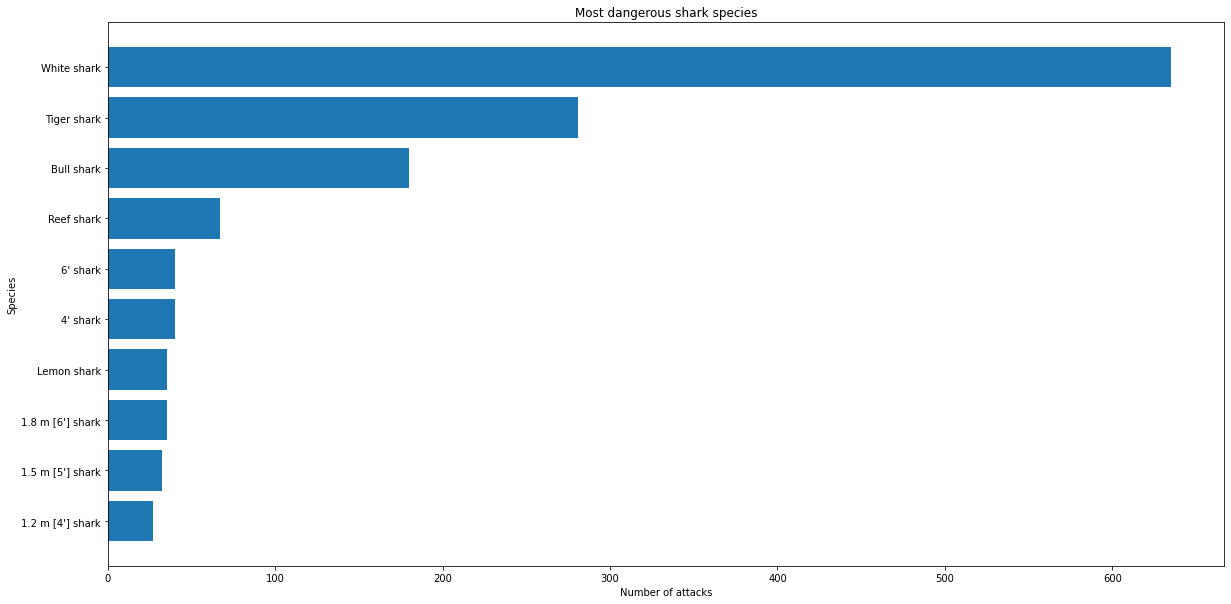

In [46]:
dfsharkspeciescount = df["Species"].value_counts().head(10).to_frame()

xvalues = dfsharkspeciescount.index
yvalues = dfsharkspeciescount["Species"]


fig, ax = plt.subplots()
ax.barh(xvalues, yvalues)
fig.set_size_inches(20, 10)
plt.title("Most dangerous shark species")
plt.xlabel("Number of attacks")
plt.ylabel("Species")
ax.invert_yaxis()
plt.show()

# Are Children more likely to get attacked by sharks?

Conclusion: no, children are not more likely to get attacked by sharks. The age group 11 - 20 is most likely to be attacked by sharks, followed by the age group of 21 - 30. Though there are some decisions made when cleaning the data which had an effect on the outcome. All rows where there was no number (so also the rows with multiple ages) mentioned, were left out. Though this does not necessarily lead to bias, since these rows concerned victims of all age groups. 

Age
1       2
3       5
5       7
6      14
7      18
8      25
9      31
10     53
11     33
12     69
13     92
14     98
15    138
16    137
17    146
18    147
19    140
20    138
21    114
22    113
23     78
24    103
25    105
26     81
27     75
28     79
29     75
30     76
31     49
32     69
Name: Case Number, dtype: int64

,Case Number,Type,Activity,Age,Fatal,Species
0,2018.06.25,Boating,Paddling,57,N,White shark
1,2018.06.18,Unprovoked,Standing,11,N,NaN
2,2018.06.09,Invalid,Surfing,48,N,NaN
6,2018.06.03.a,Unprovoked,Swimming,18,Y,Tiger shark
7,2018.05.27,Unprovoked,Fishing,52,N,Lemon shark
...,...,...,...,...,...,...
6242,ND.0064,Unprovoked,Swimming naked near a date palm where many dat...,6,N,Bull shark
6243,ND.0063,Unprovoked,Swimming in section of river used for washing ...,16,N,Bull shark
6254,ND.0051,Provoked,"Shark fishing, knocked overboard",50,Y,NaN
6276,ND.0026,Unprovoked,Standing,16,Y,Tiger shark


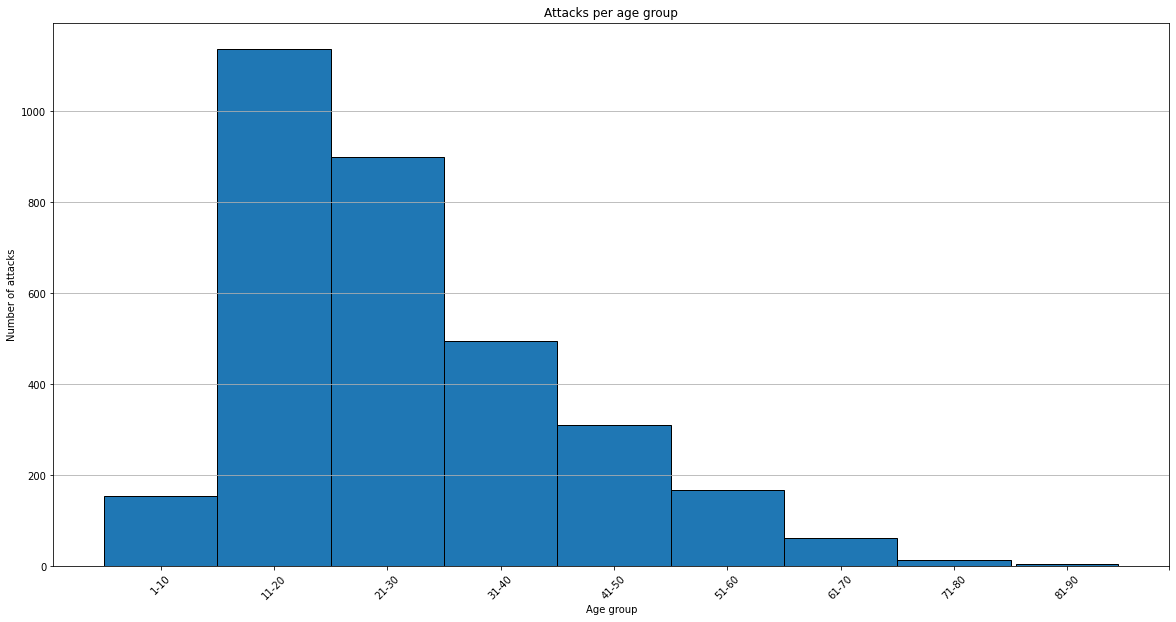

In [47]:
#Get the number of attacks per age
groupedagedata = df.dropna(subset=["Age"])
groupedagedata = df.groupby("Age")["Case Number"].count()
display(groupedagedata.head(30))

#create a histogram with bins with a range of ages. Each bin has 10 ages
binslabels = ["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90"]
bins = [1, 11, 21, 31, 41, 51, 61, 71, 81, 90]

#binsdata = pd.cut(df['Age'], [0,10, 20, 30, 40, 50, 60, 70, 80, 90], labels= binslabels, include_lowest=True).value_counts()



dfwithage = df.dropna(subset=["Age"])
display(dfwithage)

fig, ax = plt.subplots()
plt.hist(dfwithage["Age"], bins=bins, histtype='bar', ec='black', align='left')
ax.set_xticks(bins) #do this to set the ticks in each bar/bin
ax.set_xticklabels(binslabels,rotation=45)
fig.set_size_inches(20, 10)
plt.title("Attacks per age group")
plt.xlabel("Age group")
plt.ylabel("Number of attacks")
plt.grid(axis="y")
plt.show()



# Are shark attacks where sharks were provoked more or less dangerous?
There is an indication that shark attacks where sharks were provoked are less dangerous, because the percentage of fatal attacks is lower compared to unprovoked attacks. However, the total number of provoked attacks is much lower than the number of unprovoked attacks (250 vs. 4000), so there is not enough data on provoked attacks to be able to draw a hard conclusion. 

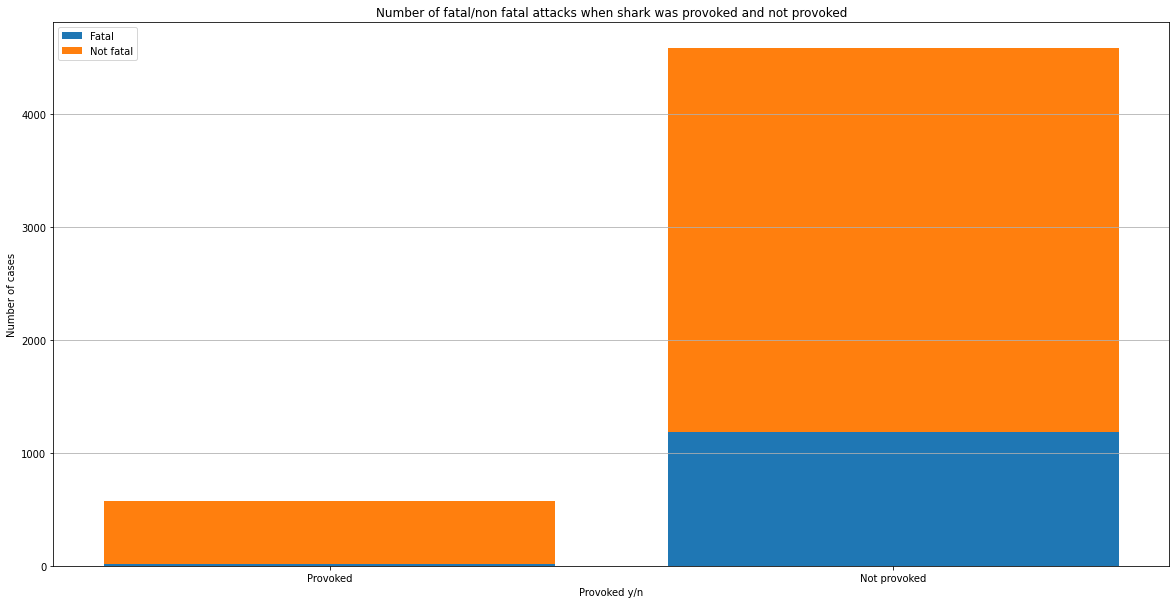

'The percentage of fatal attacks when sharks were provoked is 3.32%'

'The percentage of fatal attacks when sharks were not provoked is 25.75%'

In [48]:
#Get the number of fatal and non fatal attacks, both provoked and unprovoked attacks
provokedfatalcount = len(df.loc[(df["Fatal"] == "Y") & (df["Type"] == "Provoked")].index)
nonprovokedfatalcount = len(df.loc[(df["Fatal"] =="Y") & (df["Type"] == "Unprovoked")].index)
provokednonfatalcount = len(df.loc[(df["Fatal"] == "N") & (df["Type"] == "Provoked")].index)
nonprovokednonfatalcount = len(df.loc[(df["Fatal"] == "N") & (df["Type"] == "Unprovoked")].index)


#Calculate percentages of fatal attacks, for both provoked and unprovoked attacks
Fatalpercentageprovoked = round(provokedfatalcount / (provokedfatalcount + provokednonfatalcount) * 100, 2)
Fatalpercentagenonprovoked = round(nonprovokedfatalcount / (nonprovokedfatalcount + nonprovokednonfatalcount) * 100, 2)

#prepare data for graph. Decided to make a stacked bar chart, with one bar for provoked attacks and one for
labels = ["Provoked", "Not provoked"]
Fatalcounts = [provokedfatalcount, nonprovokedfatalcount]
NonFatalcounts = [provokednonfatalcount,nonprovokednonfatalcount]

fig, ax = plt.subplots()
plt.bar(labels, Fatalcounts, label="Fatal")
plt.bar(labels, NonFatalcounts, bottom=Fatalcounts, label = "Not fatal")
fig.set_size_inches(20, 10)
plt.title("Number of fatal/non fatal attacks when shark was provoked and not provoked")
plt.xlabel("Provoked y/n")
plt.ylabel("Number of cases")
plt.grid(axis="y")
ax.legend()
plt.show()

display(f"The percentage of fatal attacks when sharks were provoked is {Fatalpercentageprovoked}%")
display(f"The percentage of fatal attacks when sharks were not provoked is {Fatalpercentagenonprovoked}%")

# Are certain activities more likely to result in a shark attack?
The most shark attacks occured when the victims were fishing, surfing and swimming. Note: to simplify the analysis, we did not make a distinction between different types of fishing, diving, surfing and swimming. So for example "Body surfing" and "Wind surfing" were all regarded as "Surfing". 

Though fishing, surfing and swimming were the activities which were performed when most attacks happened, you cannot say people are more likely to get attacked by a shark when doing one of these activities, for multiple reasons:

First, there is no good data source on the total number of people performing these and other activities. Since fishing, surfing and swimming are probably the water activities people do the most, it is not surprising the number of attacks related to these activities is higher. 
Second, there are probably many other (area-specific) factors which should be taken into account which are not included in the dataset, such as the shallowness of the water on the exact location of the attack. It would therefore make more sense to compare the attacks within one area/region, but that is beyond the scope of this assignment. 

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


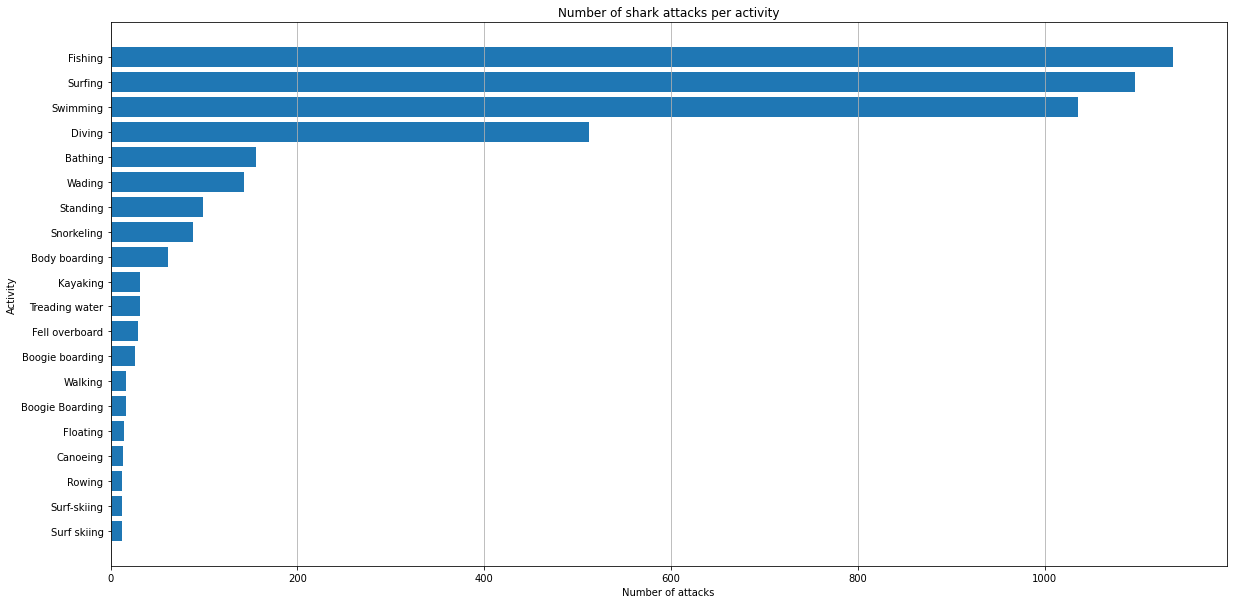

In [49]:
# Filter out rows where activity is null and then group and sort
df2 = df.dropna(subset=["Activity"])
groupeddf2 = df2.groupby(["Activity"])["Case Number"].count().to_frame()
sortedgroupeddf2 = groupeddf2.sort_values(by=['Case Number'], ascending = False)
#display(sortedgroupeddf2) # You can see there are many rows which contain the word "fishing". We should transform all these values into one. Do the same for diving, swimming and surfing

# Transform all strings containing a substring to the correct activity string
df2.loc[df2["Activity"].str.contains("fishing", na=False, case=False), "Activity"] = "Fishing"
df2.loc[df2["Activity"].str.contains("diving", na=False, case=False), "Activity"] = "Diving"
df2.loc[df2["Activity"].str.contains("swimming", na=False, case=False), "Activity"] = "Swimming"
df2.loc[df2["Activity"].str.contains("surfing", na=False, case=False), "Activity"] = "Surfing"

# Group and sort again
groupeddf2 = df2.groupby(["Activity"])["Case Number"].count().to_frame()
sortedgroupeddf2 = groupeddf2.sort_values(by=['Case Number'], ascending = False)
#display(sortedgroupeddf2)

# Create horizontal bar chart to compare attacks per activity
dfhead = sortedgroupeddf2.head(20)
fig, ax = plt.subplots()
ax.barh( dfhead.index, dfhead["Case Number"] )
fig.set_size_inches(20, 10)
plt.title("Number of shark attacks per activity")
plt.xlabel("Number of attacks")
plt.ylabel("Activity")
plt.grid(axis="x")
ax.invert_yaxis()
plt.show()